# Подготовка библиотек

In [9]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [10]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Проверить устройства для кераса

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5028896769658131778
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3699331457266453353
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Функции для визуализации

In [12]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [13]:
DATASET_PATH = '/content/clothing-co-parsing/photos/'
MASKS_PATH = '/content/clothing-co-parsing/annotations/pixel-level/'

In [14]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [15]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [16]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [17]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

In [18]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [19]:
len(train)

6424

In [20]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

далее обучайте на датасете train, для валидации используйте датасет test аналогично как на занятии

In [21]:
tf.random.set_seed(42)

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [23]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')]

In [24]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

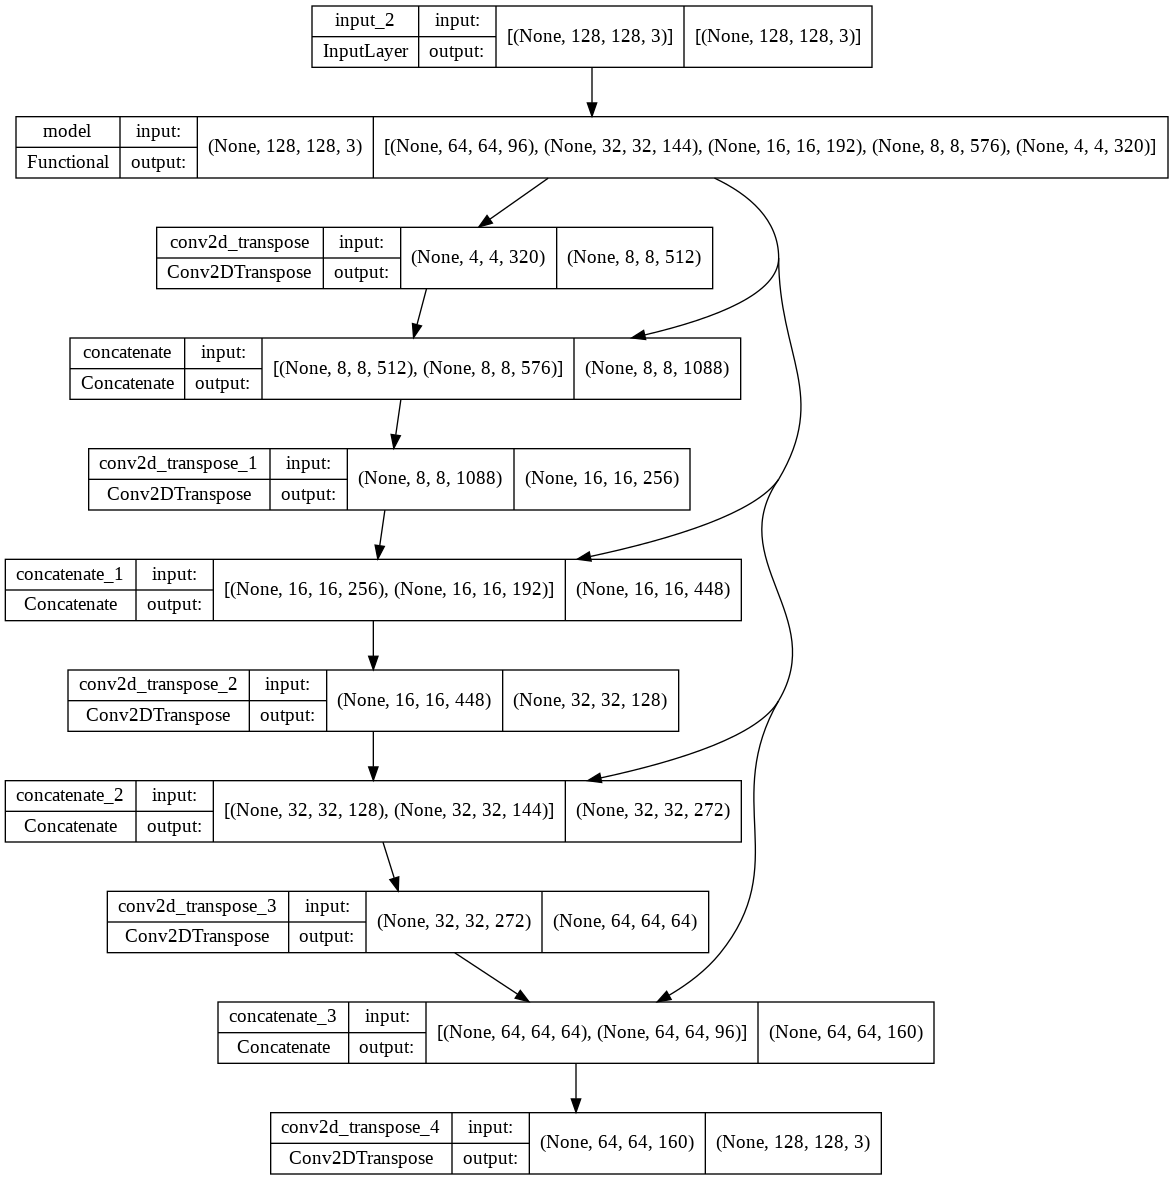

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

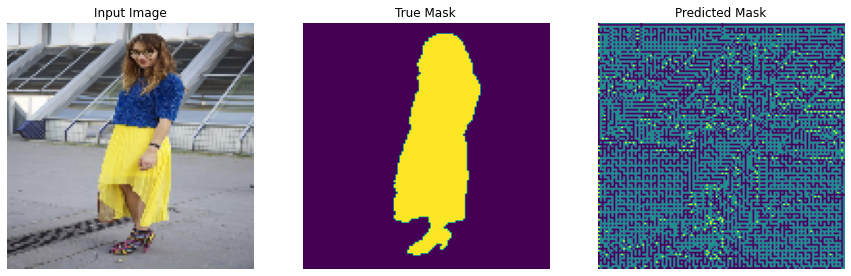

In [27]:
show_predictions(model)

# Обучение модели

Epoch 1/50
200/201 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9721

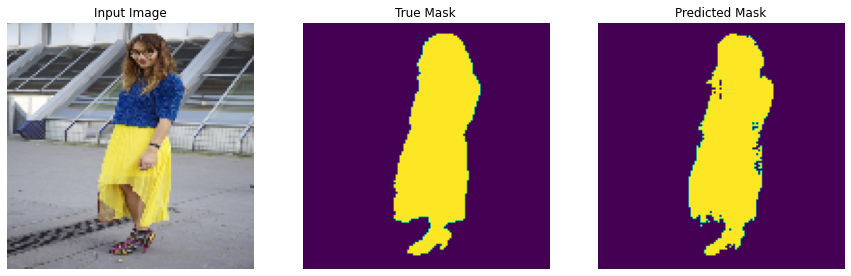


Sample Prediction after epoch 1

201/201 [==============================] - 13s 64ms/step - loss: 0.0718 - accuracy: 0.9721 - val_loss: 0.0842 - val_accuracy: 0.9678
Epoch 2/50
201/201 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9761

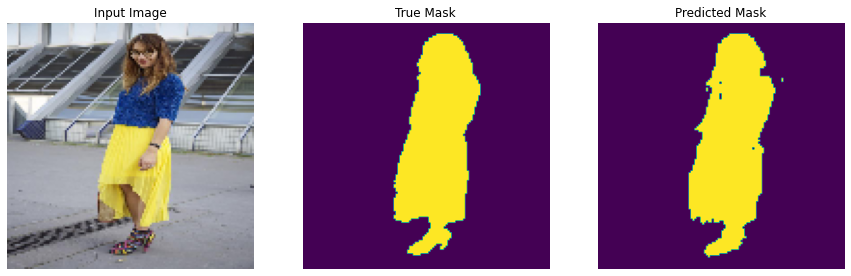


Sample Prediction after epoch 2

201/201 [==============================] - 13s 65ms/step - loss: 0.0610 - accuracy: 0.9761 - val_loss: 0.0727 - val_accuracy: 0.9739
Epoch 3/50
200/201 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9791

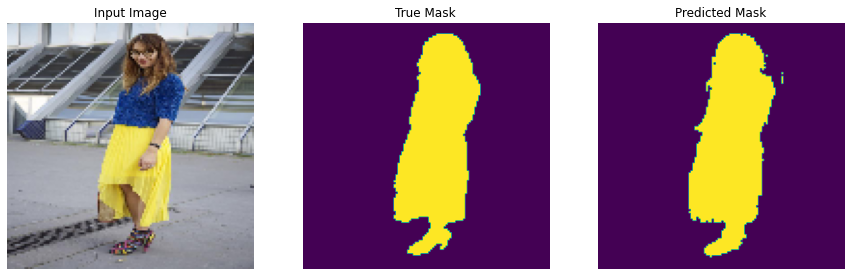


Sample Prediction after epoch 3

201/201 [==============================] - 13s 65ms/step - loss: 0.0533 - accuracy: 0.9791 - val_loss: 0.0723 - val_accuracy: 0.9753
Epoch 4/50
201/201 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9813

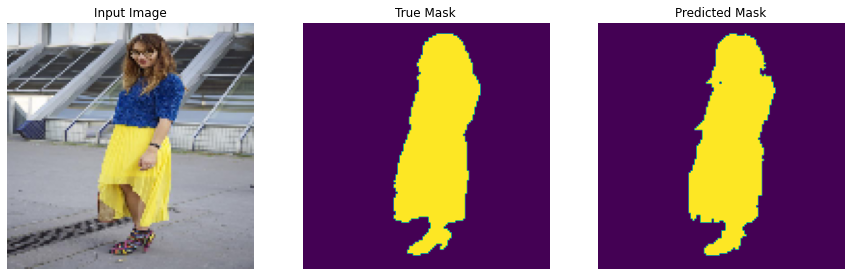


Sample Prediction after epoch 4

201/201 [==============================] - 14s 68ms/step - loss: 0.0473 - accuracy: 0.9813 - val_loss: 0.0724 - val_accuracy: 0.9752
Epoch 5/50
201/201 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9831

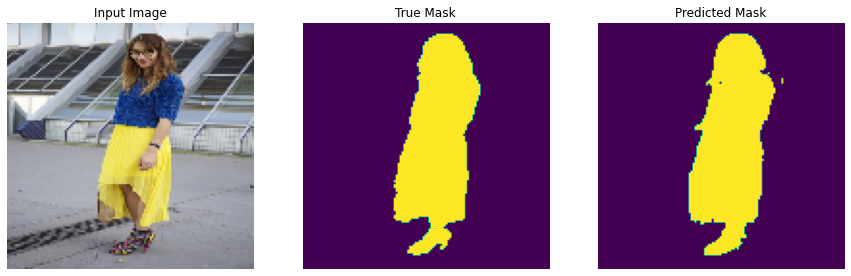


Sample Prediction after epoch 5

201/201 [==============================] - 13s 67ms/step - loss: 0.0429 - accuracy: 0.9831 - val_loss: 0.0757 - val_accuracy: 0.9758
Epoch 6/50
201/201 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9847

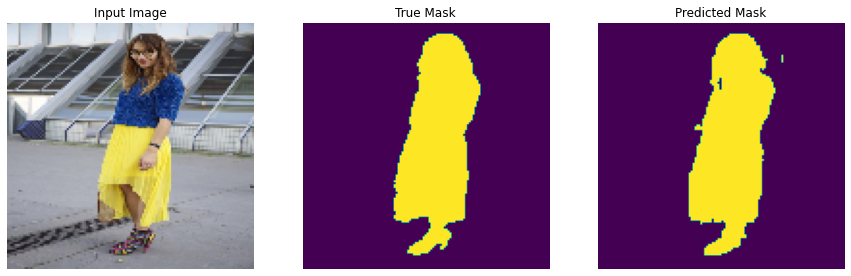


Sample Prediction after epoch 6

201/201 [==============================] - 14s 67ms/step - loss: 0.0386 - accuracy: 0.9847 - val_loss: 0.0781 - val_accuracy: 0.9759
Epoch 7/50
200/201 [============================>.] - ETA: 0s - loss: 0.0357 - accuracy: 0.9858

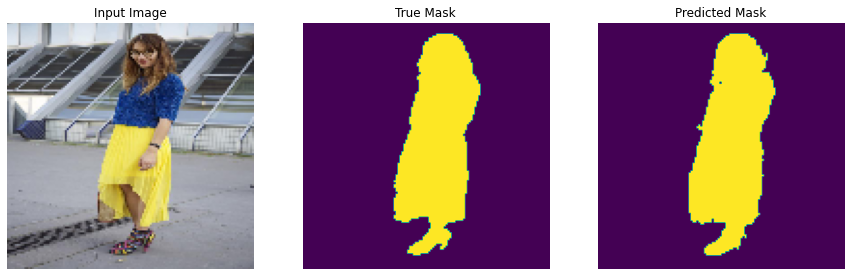


Sample Prediction after epoch 7

201/201 [==============================] - 13s 66ms/step - loss: 0.0357 - accuracy: 0.9859 - val_loss: 0.0801 - val_accuracy: 0.9761
Epoch 8/50
201/201 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9871

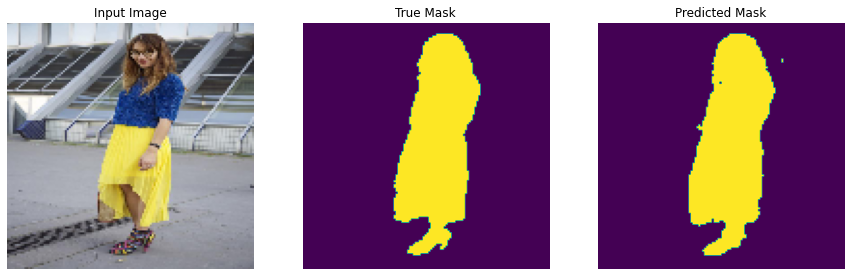


Sample Prediction after epoch 8

201/201 [==============================] - 13s 66ms/step - loss: 0.0322 - accuracy: 0.9871 - val_loss: 0.0855 - val_accuracy: 0.9758
Epoch 9/50
201/201 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9879

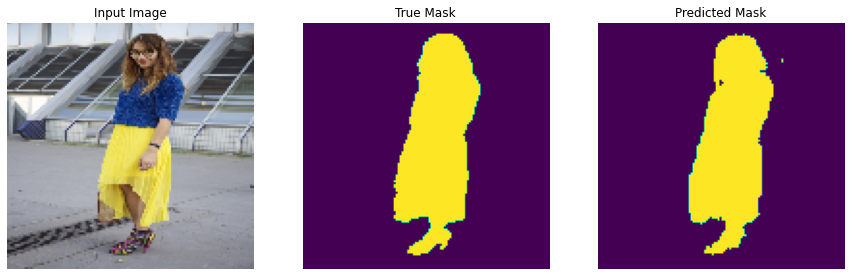


Sample Prediction after epoch 9

201/201 [==============================] - 13s 67ms/step - loss: 0.0303 - accuracy: 0.9879 - val_loss: 0.0916 - val_accuracy: 0.9733
Epoch 10/50
201/201 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9888

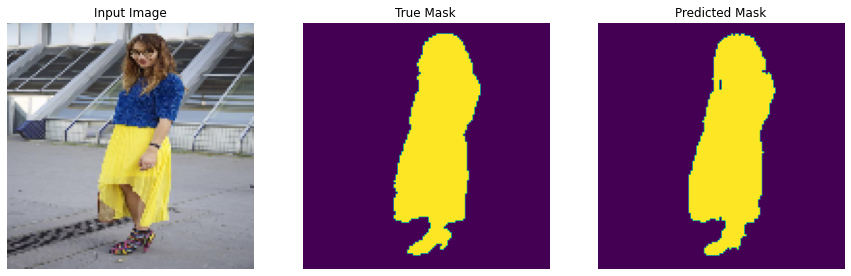


Sample Prediction after epoch 10

201/201 [==============================] - 14s 67ms/step - loss: 0.0279 - accuracy: 0.9888 - val_loss: 0.0900 - val_accuracy: 0.9754


In [29]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 50

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback(), EarlyStopping(monitor='val_accuracy', patience=3)])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

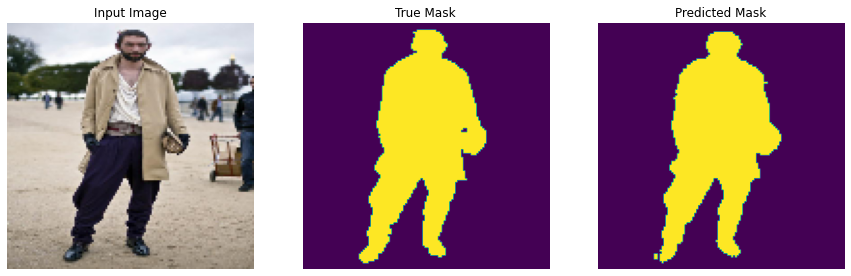

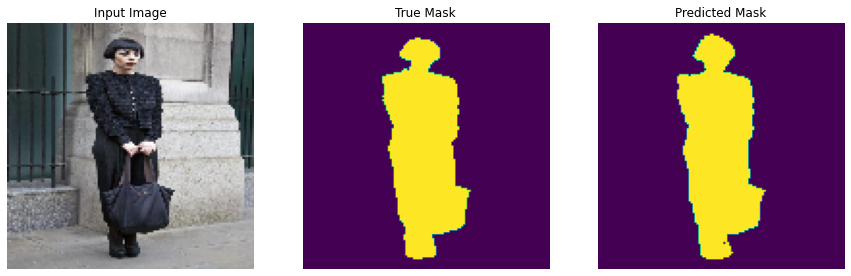

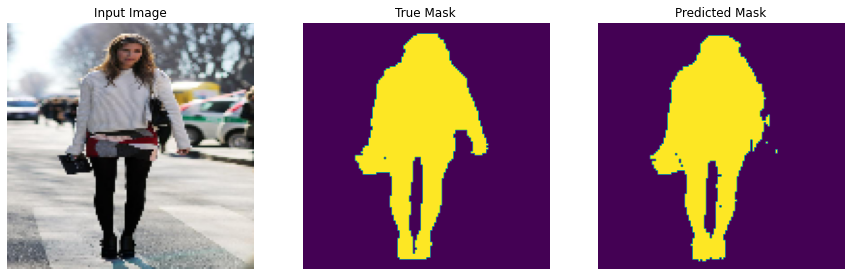

In [30]:
show_predictions(model, test, 3)